<a href="https://colab.research.google.com/github/fedemoss/Clustering-of-Spotify-Songs/blob/main/spotify_Clustering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---

En este proyecto, tomamos datasets de canciones + features + letras para temas que sacamos de Spotify. Queremos ver como se distribuyen las canciones en un espacio de componentes principales. Para eso, hacemos un análisis de componentes principales (PCA) y un clustereo con Kmeans. La idea detrás de todo esto es hacer un estudio de cómo se agrupan las canciones y, en particular, a dónde van a parar las canciones del 'TOP 50 Argentina'. 

El esquema de trabajo es el siguiente:

-   Hacemos PCA.

-   Dividimos en 3 Clusters (Kmeans, K=3).

-   Ponemos la info de cada cluster como nuevos features binarios en el Dataset primario.

-   Vemos como se distribuyen los artistas en cada Cluster.

-   Hacemos Wordclouds de Palabras frecuentes en las letras correspondientes a las cnaciones que pertenecen a cada cluster.

-   Incorporamos un nuevo dataset y predecimos a que cluster va a parar cada nueva cancion (KNN Clasiffier).

-   Definimos la Balanced Accuracy para ver cuan bueno es el predictor

---
---

In [1]:
#Librerias y datasets que usaremos
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # K-means
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cleaning Dataset

In [126]:
filename_features = '/content/drive/My Drive/LaboDatos/TRABAJO FINAL/df_FINAL_features_random.csv'
filename_lyrics = '/content/drive/My Drive/LaboDatos/TRABAJO FINAL/df_FINAL_lyrics_random.csv'
df_features = pd.read_csv(filename_features) # Levantamos los datos
df_lyrics = pd.read_csv(filename_lyrics)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2675 non-null   object 
 1   danceability      2675 non-null   float64
 2   energy            2675 non-null   float64
 3   key               2675 non-null   float64
 4   loudness          2675 non-null   float64
 5   mode              2675 non-null   float64
 6   speechiness       2675 non-null   float64
 7   acousticness      2675 non-null   float64
 8   instrumentalness  2675 non-null   float64
 9   liveness          2675 non-null   float64
 10  valence           2675 non-null   float64
 11  tempo             2675 non-null   float64
 12  type              2675 non-null   object 
 13  id                2675 non-null   object 
 14  duration_ms       2675 non-null   float64
 15  time_signature    2675 non-null   float64
 16  Disc number       2675 non-null   int64  


Limpiemos un poco el dataset: voy a dropear features que, despues de mucho analisis, no son relevantes. Si clusterizamos con la feature 'KEY' por ejemplo, esta termina siendo la feature que más pesa. Y no es lo que queremos, queremos ver como se agrupan canciones en función de cosas más isotéricas... bailabilidad, loudness, energy, etc... 

In [127]:
#Definimos un par de cosas

songs = df_features['Song']
artists = df_features['Artist']

#Dropeamos algunas cosas como: type, unnamed, song,...
df_features = df_features.drop(['type','Unnamed: 0','mode','Song', 'Artist','key'], axis=1)

#cambiamos el index
df_features = df_features.set_index('id')

#Datetime
df_features['year'] = pd.DatetimeIndex(df_features['Date']).year
#df_features['month'] = pd.DatetimeIndex(df_features['Date']).month
df_features = df_features.drop(['Date'], axis=1)

df_features.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Disc number,Total tracks,Track number,Popularity,TOP,year
id,,,,,,,,,,,,,,,,,
1MRhIdcloOD0uiiG3ybXGX,0.532,0.776,-7.873,0.0300,0.024000,0.000419,0.3580,0.667,137.736,206200.0,4.0,1,10,3,63,0,1991
0Ruvs5IxqkGqQVWCO2oRpw,0.537,0.749,-6.336,0.0284,0.000645,0.527000,0.1970,0.735,124.224,213067.0,4.0,1,18,12,62,0,2007
0C9V5jMElp7laZZdsCHufD,0.636,0.593,-5.181,0.0567,0.303000,0.000014,0.1080,0.742,145.972,237547.0,4.0,1,12,1,62,0,2004
3nnDwYz3dEd4p2ESdpS1G0,0.512,0.845,-3.164,0.0381,0.100000,0.000353,0.2640,0.659,139.955,250173.0,4.0,1,12,2,60,0,2005
0E8XJWxq5ovryhm0gqqiXd,0.559,0.847,-4.538,0.0379,0.110000,0.000000,0.0858,0.544,123.924,275587.0,4.0,1,14,9,58,0,2004


El TOP 50 Argentina

In [128]:
indiceTOP = np.logical_not(df_features['TOP'] == 1) 

df_TOP = df_features.drop(df_features[indiceTOP].index) #dropeo los indices 0 y me quedo con los 1
df_TOP_pca = df_TOP #.drop(['Song','Artist'], axis=1)

# PCA

In [129]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X = df_features.values
p = np.size(df_features.keys()) # Todas las features son componentes principales
pca = PCA(n_components = p)

size = np.size(df_features['loudness']) #size de alguna feature random
X.reshape(size, -1)
X.astype('float32') # transformamos el tipo de datos a "float32"

# Scaler
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)

# FIT PCA
pca.fit(X)
X_pca = pca.transform(X)

#CLUSTERS TOP
X_top = df_TOP_pca.values
p = np.size(df_TOP_pca.keys()) # Todas las features son componentes principales
pca = PCA(n_components = p)

size = np.size(df_TOP_pca['loudness']) #size de alguna feature random
X_top.reshape(size, -1)
X_top.astype('float32') # transformamos el tipo de datos a "float32"

# Scaler
scaler = MinMaxScaler()
scaler.fit(X_top)
X_top=scaler.transform(X_top)

# FIT PCA
pca.fit(X_top)
X_pca_top = pca.transform(X_top)

Curvas de fraccion de varianza y de varianza acumulada

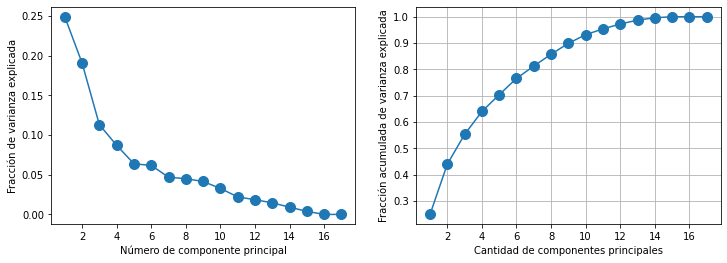

In [130]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')
plt.grid()

Necesitamos al menos 8 componentes principales para que los datos den informacion relevante. 

Pro simplicidad, veamos como son las primeras 4 componentes... 

Text(0, 0.5, 'Segunda componente principal')

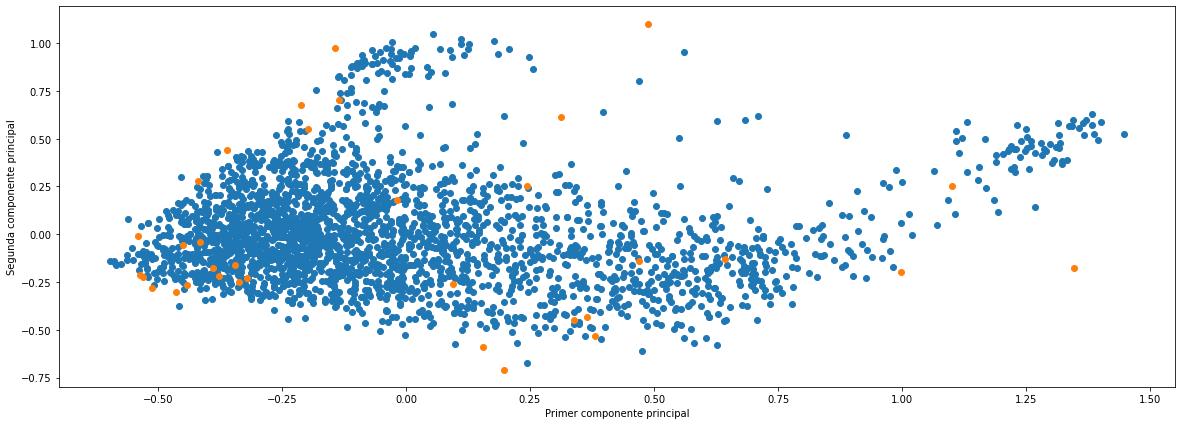

In [131]:
# Creación del modelo de PCA con 4 componentes
pca = PCA(n_components = 4)

# Ajuste y transformación de los datos
pca.fit(X)
X_pca = pca.transform(X)

#PLOTEAMOS
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])
ax.scatter(X_pca_top[:, 0], X_pca_top[:, 1])
#ax.legend('No top','Top')

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Veamos como pesa cada feature en cada componente (para las 4).

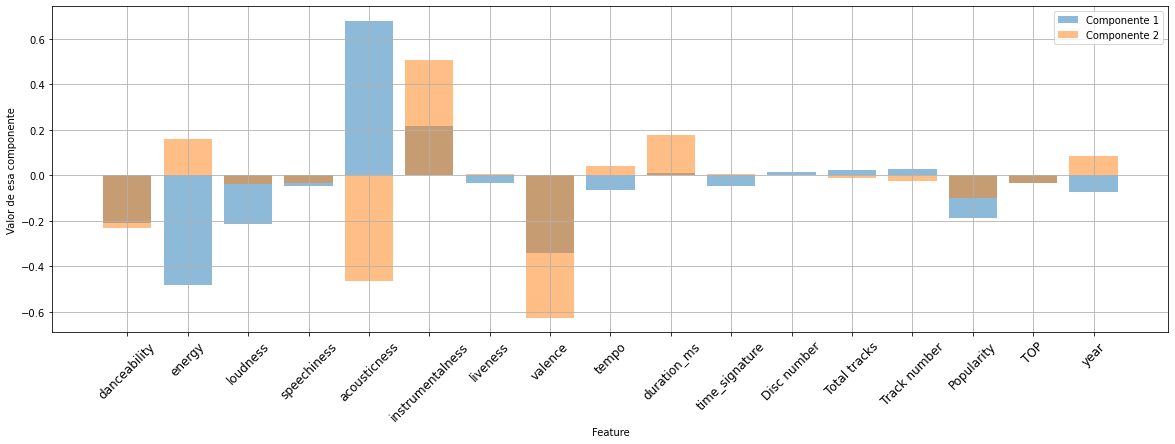

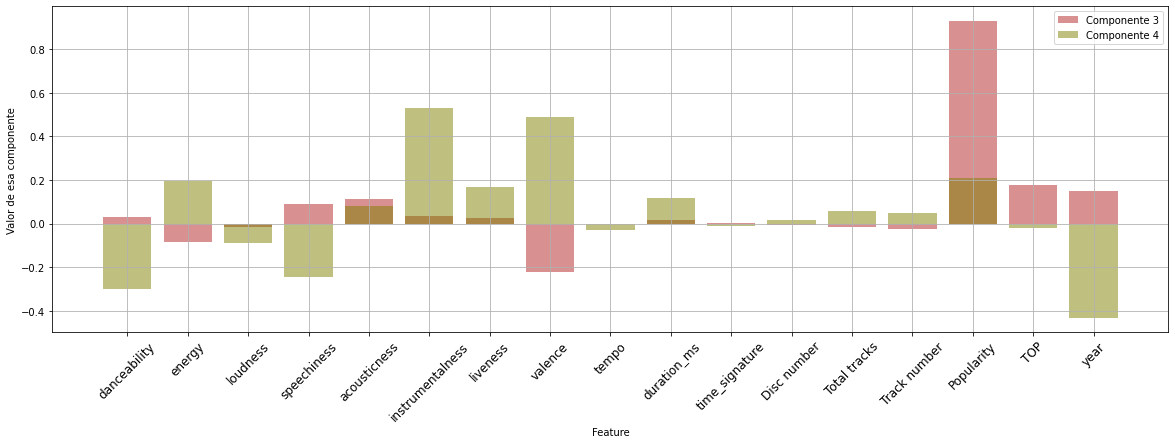

In [132]:
features=list(df_features.keys()) #features
len_features=len(features)

plt.figure(figsize=(20,6)) #plot 1
plt.bar(np.arange(len_features),pca.components_[0],label='Componente 1',alpha=0.5)
plt.bar(np.arange(len_features),pca.components_[1],label='Componente 2',alpha=0.5)
plt.legend()
plt.xticks(ticks=np.arange(len(features)),labels=features,rotation=45,fontsize=12)
plt.xlabel('Feature')
plt.ylabel('Valor de esa componente')
plt.grid()

plt.figure(figsize=(20,6)) #plot 2
plt.bar(np.arange(len_features),pca.components_[2],label='Componente 3',alpha=0.5,color='firebrick')
plt.bar(np.arange(len_features),pca.components_[3],label='Componente 4',alpha=0.5,color='olive')
plt.legend()
plt.xticks(ticks=np.arange(len(features)),labels=features,rotation=45,fontsize=12)
plt.xlabel('Feature')
plt.ylabel('Valor de esa componente')
plt.grid()

# K means

No handles with labels found to put in legend.


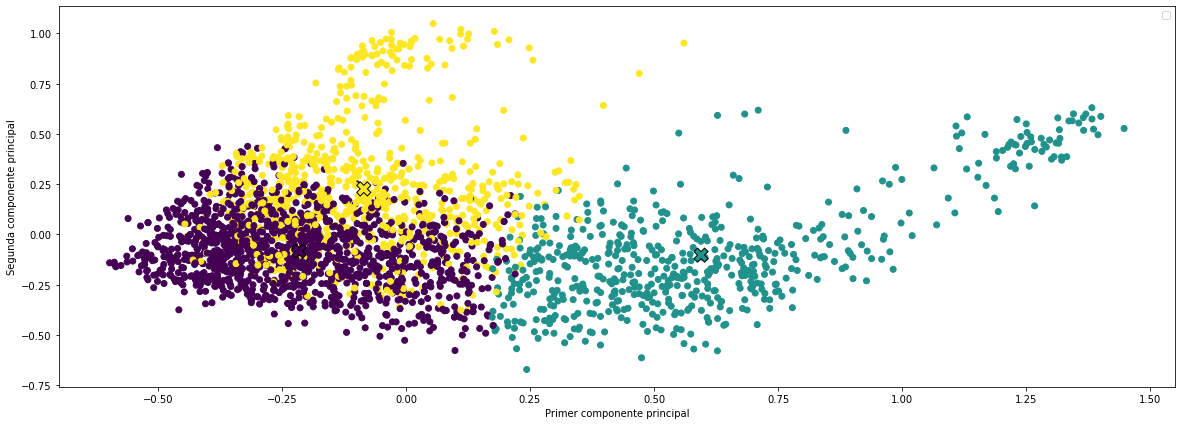

In [133]:
from sklearn.cluster import KMeans 

# Creación del modelo KMeans con k = 3,4...
# Probé con ambos.. k=3 es, por inspección visual, la que va. 
kmeans = KMeans(n_clusters=3)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

# Guardo las posiciones de los centroids
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black')
ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')
plt.show()

---

Miremos que canciones van a a parar a cada cluster

In [134]:
labels = kmeans.labels_ # Array de labels

# Iniciamos un for con k iteraciones
cluster0 = np.zeros(len(labels))
cluster1 = np.zeros(len(labels))
cluster2 = np.zeros(len(labels))
cluster3 = np.zeros(len(labels))
j=0
for i in range(len(labels)):
  if labels[i]==0:
    cluster0[j] = 1
    cluster1[j] = 0
    cluster2[j] = 0
    cluster3[j] = 0
    j=j+1
  if labels[i]==1:
    cluster0[j] = 0
    cluster1[j] = 1
    cluster2[j] = 0
    cluster3[j] = 0
    j=j+1
  if labels[i]==2:
    cluster0[j] = 0
    cluster1[j] = 0
    cluster2[j] = 1
    cluster3[j] = 0
    j=j+1
  if labels[i]==3:
    cluster0[j] = 0
    cluster1[j] = 0
    cluster2[j] = 0
    cluster3[j] = 1
    j=j+1
  

print(cluster0[:20])
print(cluster1[:20])
print(cluster2[:20])
print(cluster3[:20])

[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Agregamos esto como features en el Dataset

In [135]:
#Volvemos al dataframe.. 
df_features['cluster 0'] = cluster0
df_features['cluster 1'] = cluster1
df_features['cluster 2'] = cluster2
#df_features['cluster 3'] = cluster3

df_features.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Disc number,Total tracks,Track number,Popularity,TOP,year,cluster 0,cluster 1,cluster 2
id,,,,,,,,,,,,,,,,,,,,
1MRhIdcloOD0uiiG3ybXGX,0.532,0.776,-7.873,0.0300,0.024000,0.000419,0.3580,0.667,137.736,206200.0,4.0,1,10,3,63,0,1991,1.0,0.0,0.0
0Ruvs5IxqkGqQVWCO2oRpw,0.537,0.749,-6.336,0.0284,0.000645,0.527000,0.1970,0.735,124.224,213067.0,4.0,1,18,12,62,0,2007,1.0,0.0,0.0
0C9V5jMElp7laZZdsCHufD,0.636,0.593,-5.181,0.0567,0.303000,0.000014,0.1080,0.742,145.972,237547.0,4.0,1,12,1,62,0,2004,1.0,0.0,0.0
3nnDwYz3dEd4p2ESdpS1G0,0.512,0.845,-3.164,0.0381,0.100000,0.000353,0.2640,0.659,139.955,250173.0,4.0,1,12,2,60,0,2005,1.0,0.0,0.0
0E8XJWxq5ovryhm0gqqiXd,0.559,0.847,-4.538,0.0379,0.110000,0.000000,0.0858,0.544,123.924,275587.0,4.0,1,14,9,58,0,2004,1.0,0.0,0.0


# Lyrics + features Dataset

In [136]:
#Pulimos un poco el dataset df_lyrics
df_lyrics = df_lyrics.rename(columns={'Unnamed: 0': 'id'}).copy()
df_lyrics = df_lyrics.rename(columns={'0':'Song', '1':'Artist', '2': 'Lyrics'}).copy()
df_lyrics = df_lyrics.set_index('id').copy()

In [137]:
#df mergeado con Nans
df_merged = df_lyrics.merge(df_features, on='id')

In [138]:
#df mergeado sin Nans
df_lyrics_drop = df_lyrics.dropna()
df_merged_drop = df_lyrics_drop.merge(df_features, on='id')

In [139]:
#df clusters
indice_cluster0 = np.logical_not(df_merged['cluster 0'] == 1) #los indices que son 0
indice_cluster1 = np.logical_not(df_merged['cluster 1'] == 1)
indice_cluster2 = np.logical_not(df_merged['cluster 2'] == 1)
#indice_cluster3 = np.logical_not(df_merged['cluster 3'] == 1)

df_cluster0 = df_merged.drop(df_merged[indice_cluster0].index) #dropeo los indices 0 y me quedo con los 1
df_cluster1 = df_merged.drop(df_merged[indice_cluster1].index)
df_cluster2 = df_merged.drop(df_merged[indice_cluster2].index)
#df_cluster3 = df_merged.drop(df_merged[indice_cluster3].index)

print('Size cluster 0:',np.size(df_cluster0['cluster 0']))
print('Size cluster 1:',np.size(df_cluster1['cluster 0']))
print('Size cluster 2:',np.size(df_cluster2['cluster 0']))
#print('Size cluster 3:',np.size(df_cluster3['cluster 0']))

Size cluster 0: 1553
Size cluster 1: 608
Size cluster 2: 772


In [140]:
#df clusters sin NaNs
indice_cluster0 = np.logical_not(df_merged_drop['cluster 0'] == 1) #los indices que son 0
indice_cluster1 = np.logical_not(df_merged_drop['cluster 1'] == 1)
indice_cluster2 = np.logical_not(df_merged_drop['cluster 2'] == 1)
#indice_cluster3 = np.logical_not(df_merged_drop['cluster 3'] == 1)


df_cluster0_drop = df_merged_drop.drop(df_merged_drop[indice_cluster0].index) #dropeo los indices 0 y me quedo con los 1
df_cluster1_drop = df_merged_drop.drop(df_merged_drop[indice_cluster1].index)
df_cluster2_drop = df_merged_drop.drop(df_merged_drop[indice_cluster2].index)
#df_cluster3_drop = df_merged_drop.drop(df_merged_drop[indice_cluster3].index)

print('Size cluster 0:',np.size(df_cluster0_drop['cluster 0']))
print('Size cluster 1:',np.size(df_cluster1_drop['cluster 0']))
print('Size cluster 2:',np.size(df_cluster2_drop['cluster 0']))
#print('Size cluster 3:',np.size(df_cluster3_drop['cluster 0']))

Size cluster 0: 725
Size cluster 1: 95
Size cluster 2: 167


In [141]:
#df artists
df_artists_cluster0 = df_cluster0['Artist']
df_artists_cluster1 = df_cluster1['Artist']
df_artists_cluster2 = df_cluster2['Artist']

indice0 = np.logical_not(df_artists_cluster0 != 'Various Artists') #Dropeamos los various artists
indice1 = np.logical_not(df_artists_cluster1 != 'Various Artists')
indice2 = np.logical_not(df_artists_cluster2 != 'Various Artists')

df_cluster0 = df_cluster0.drop(df_cluster0[indice0].index)
df_cluster1 = df_cluster1.drop(df_cluster1[indice1].index)
df_cluster2 = df_cluster2.drop(df_cluster2[indice2].index)

df_artists_cluster0 = df_cluster0['Artist'] #again
df_artists_cluster1 = df_cluster1['Artist']
df_artists_cluster2 = df_cluster2['Artist']

# WordClouds of Artists in each Group

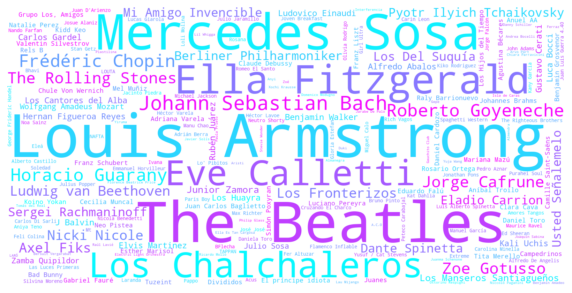

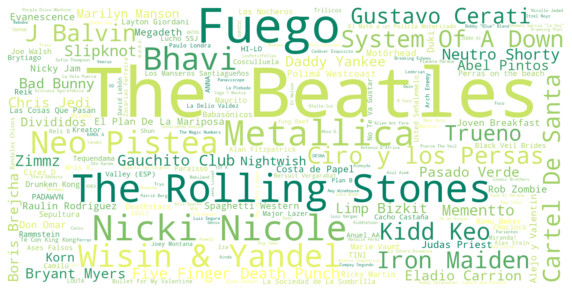

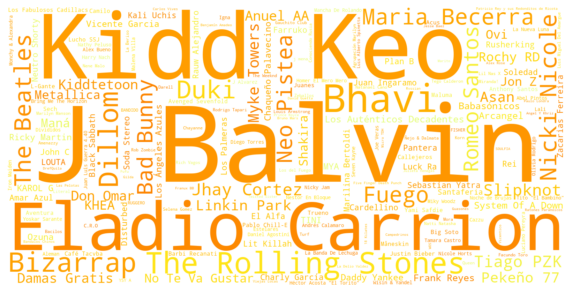

In [31]:
#Wordcloud Artists Clusters
from wordcloud import WordCloud # importo la funcion WordCloud

d = df_artists_cluster0
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'cool' # La gama de colores para coloreal
               ).generate_from_frequencies(d.value_counts().to_dict())
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()
d = df_artists_cluster1
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'summer' # La gama de colores para coloreal
               ).generate_from_frequencies(d.value_counts().to_dict())
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()
d = df_artists_cluster2
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'Wistia' # La gama de colores para coloreal
               ).generate_from_frequencies(d.value_counts().to_dict())
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()

# WordsClouds of Lyrics in each Group + Cleaning Lyrics

Armemos wordclouds de las letras... pero primero limpiemos los datos:


OBS: Las letras ya estaban bastabte limpias.. porque hay una prelimpieza en el armado del dataset.

In [32]:
import re       # libreria de expresiones regulares
import string   # libreria de cadena de caracteres

In [33]:
# Defino una funcion que recibe un texto y devuelve el mismo texto sin singnos,
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza singnos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)                              
    return text

# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento
round1 = lambda x: clean_text_round1(x)

# Dataframe que resulta de aplicarle a las columnas la funcion de limpieza
data_clean_cluster0 = pd.DataFrame(df_cluster0_drop['Lyrics'].apply(round1))
data_clean_cluster1 = pd.DataFrame(df_cluster1_drop['Lyrics'].apply(round1))
data_clean_cluster2 = pd.DataFrame(df_cluster2_drop['Lyrics'].apply(round1))

BAG OF WORDS: Count Vectorizer

In [34]:
# Vamos a crear la matriz de documentos-terminos usando usando CountVectorizer, y excluiremos las stop words en spanish e ingles
from sklearn.feature_extraction.text import CountVectorizer

# Cargamos del paquete nltk las stopwords del espaniol a la lista "lines"
import nltk
nltk.download('stopwords') # hay que descargar este modulo en particular

lines_spa = nltk.corpus.stopwords.words('spanish')
lines_eng = nltk.corpus.stopwords.words('english')
lines_spa.extend(lines_eng) #creo una lista que contenga ambos idiomas
print(lines_spa)
print(lines_eng)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro'

In [35]:
# Inicializo el modelo excluyendo stopwords
cv = CountVectorizer(stop_words=lines_spa)
# Ajustamos el modelo y lo aplicamos al texto de nuestro dataframe generando una matriz esparsa. Luego
# Nos creamos un dataframe transformando a densa la matriz generada recien que tiene como columnas las palabras (terminos) y como filas los documentos
data_cluster0_cv = cv.fit_transform(data_clean_cluster0['Lyrics'])
data_cluster0_dtm = pd.DataFrame(data_cluster0_cv.toarray(), columns=cv.get_feature_names())

cv = CountVectorizer(stop_words=lines_spa)

data_cluster1_cv = cv.fit_transform(data_clean_cluster1['Lyrics'])
data_cluster1_dtm = pd.DataFrame(data_cluster1_cv.toarray(), columns=cv.get_feature_names())

cv = CountVectorizer(stop_words=lines_spa)

data_cluster2_cv = cv.fit_transform(data_clean_cluster2['Lyrics'])
data_cluster2_dtm = pd.DataFrame(data_cluster2_cv.toarray(), columns=cv.get_feature_names())

# Le asignamos los indices del dataframe anterior
data_cluster0_dtm.index = data_clean_cluster0.index
data_cluster1_dtm.index = data_clean_cluster1.index
data_cluster2_dtm.index = data_clean_cluster2.index

#Transponemos
data_lyrics_cluster0 = data_cluster0_dtm.transpose()
data_lyrics_cluster1 = data_cluster1_dtm.transpose()
data_lyrics_cluster2 = data_cluster2_dtm.transpose()

StopWords

In [36]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

list_text_cluster0 = list(data_clean_cluster0['Lyrics'])
list_text_cluster1 = list(data_clean_cluster1['Lyrics'])
list_text_cluster2 = list(data_clean_cluster2['Lyrics'])
text_cluster0 = (" ").join(list_text_cluster0)
text_cluster1 = (" ").join(list_text_cluster1)
text_cluster2 = (" ").join(list_text_cluster2)
text_tokens_cluster0 = word_tokenize(text_cluster0) 
text_tokens_cluster1 = word_tokenize(text_cluster1) 
text_tokens_cluster2 = word_tokenize(text_cluster2) 

all_stopwords = stopwords.words()
all_stopwords.extend(['’','ah','ahh','yeah','oh','ohh','ey','hey','uh','uhh']) #saco algunas stopwords mas

tokens_without_sw_cluster0 = [word for word in text_tokens_cluster0 if not word in all_stopwords] #remuevo stopwords
tokens_without_sw_cluster1 = [word for word in text_tokens_cluster1 if not word in all_stopwords] 
tokens_without_sw_cluster2 = [word for word in text_tokens_cluster2 if not word in all_stopwords] 

filtered_sentence_cluster0 = (" ").join(tokens_without_sw_cluster0) #Uno todo de nuevo
filtered_sentence_cluster1 = (" ").join(tokens_without_sw_cluster1)
filtered_sentence_cluster2 = (" ").join(tokens_without_sw_cluster2)

print(filtered_sentence_cluster0)
print(tokens_without_sw_cluster0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
espera agotó dejaste llamas acosté lento degradé supe perdí ¿qué cosa puedo hacer olvido moriré crimen quedará crimen quedará resolver rápida traición salimos amor tal vez busqué ego estallar ahí oh… celos vez ¿qué cosa puedo hacer olvido moriré crimen quedará crimen quedará resolver sé cuanto falta sé tarde sé olvido moriré cosa puedo hacer cosa puedo hacer ahora sé perder crimen quedará crimen quedará resolver pistones curioso motor humanidad resortes viejos amor memoria hostil tiempo paz paz narices frias noche atrs besos celular momias amor piden actor pantalla muerte cansin proyectos nuevo spaghetti rock ciclope cristal debora ambicin vomita modelos ficcin remontar barrilete tempestad slo entender ayer hoy hoy hoy actor besos celular momias amor piden actor re

In [37]:
#Count words
print('CLUSTER 0:',pd.DataFrame(tokens_without_sw_cluster0).value_counts())
print('CLUSTER 1:',pd.DataFrame(tokens_without_sw_cluster1).value_counts())
print('CLUSTER 2:',pd.DataFrame(tokens_without_sw_cluster2).value_counts())

#Sacamos lo que vemos que hay que sacar
filtered_sentence_cluster0 = filtered_sentence_cluster0.replace('’','').replace('yeah','').replace('usa','').replace('aquí','').replace('oh','').replace('ah','').replace('ahh','').replace('hey','').replace('ey','').replace('eh','').replace('uh','').replace(' ora','').replace(' let','').replace(' sé','')
filtered_sentence_cluster1 = filtered_sentence_cluster1.replace('’','').replace('yeah','').replace('usa','').replace('aquí','').replace('oh','').replace('ah','').replace('ahh','').replace('hey','').replace('ey','').replace('eh','').replace('uh','').replace(' ora','').replace(' let','').replace(' sé','')
filtered_sentence_cluster2 = filtered_sentence_cluster2.replace('’','').replace('yeah','').replace('usa','').replace('aquí','').replace('oh','').replace('ah','').replace('ahh','').replace('hey','').replace('ey','').replace('eh','').replace('uh','').replace(' ora','').replace(' let','').replace(' sé','').replace('baby','')

CLUSTER 0: let        93
solo       80
dime       79
quiero     72
amor       71
           ..
meses       1
meta        1
mete        1
metejón     1
aa          1
Length: 3367, dtype: int64
CLUSTER 1: quiero    218
ahora     217
baby      190
voy       140
noche     136
         ... 
wawa        1
hombro      1
siendo      1
venas       1
latir       1
Length: 6088, dtype: int64
CLUSTER 2: eh             1408
quiero         1109
ahora           870
baby            839
sé              763
               ... 
satea             1
estrellemos       1
estrello          1
estrellé          1
frankie           1
Length: 14920, dtype: int64


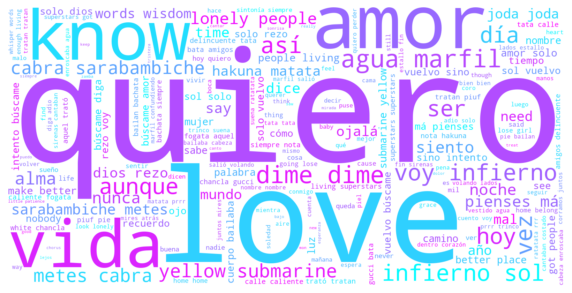

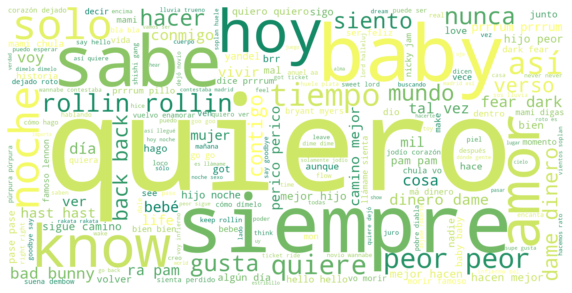

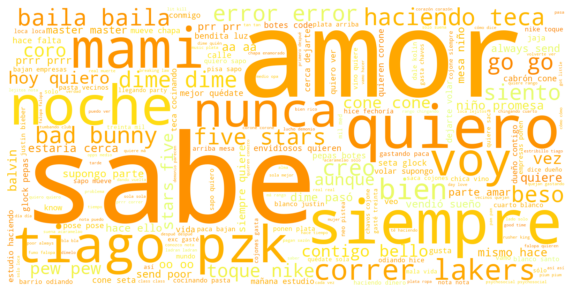

In [38]:
from wordcloud import WordCloud # importo la funcion WordCloud
import matplotlib.pyplot as plt

# Creo el objeto WordCloud con determinados parametros y utilizando nuestra lista de stopwords
 
plt.rcParams['figure.figsize'] = [16,12] # tamanio de los plots
#WC
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'cool' # La gama de colores para coloreal
               ).generate_from_text(filtered_sentence_cluster0)
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()

wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'summer' # La gama de colores para coloreal
               ).generate_from_text(filtered_sentence_cluster1)
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()

wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'Wistia' # La gama de colores para coloreal
               ).generate_from_text(filtered_sentence_cluster2)
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()

# Train-test dataset and TOP 50 study

Ahora queremos ver a que cluster van a parar las canciones del TOP 50 Argentina

In [143]:
indiceTOP = np.logical_not(df_features['TOP'] == 1) 
df_features_TOP = df_features.drop(df_features[indiceTOP].index)
df_features_TOP.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 7COGuXyTr12KvdaYXMqheC to 3VvA1wSxukMLsvXoXtlwWx
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      34 non-null     float64
 1   energy            34 non-null     float64
 2   loudness          34 non-null     float64
 3   speechiness       34 non-null     float64
 4   acousticness      34 non-null     float64
 5   instrumentalness  34 non-null     float64
 6   liveness          34 non-null     float64
 7   valence           34 non-null     float64
 8   tempo             34 non-null     float64
 9   duration_ms       34 non-null     float64
 10  time_signature    34 non-null     float64
 11  Disc number       34 non-null     int64  
 12  Total tracks      34 non-null     int64  
 13  Track number      34 non-null     int64  
 14  Popularity        34 non-null     int64  
 15  TOP               34 non-null     int64  
 16  year      

No entiendo por qué me mata 16 canciones del TOP. Hay un problema cuando cambiamos el indice (cuando seteamos index = 'id'). Indescifrable. Sospecho que debe ser algo relacionado con correr cosas en notebooks. En fin, aceptemos esto (TOP 34 Argentina :/)

In [153]:
print(df_features_TOP['cluster 0'].value_counts())
print(df_features_TOP['cluster 1'].value_counts())
print(df_features_TOP['cluster 2'].value_counts())

1.0    34
Name: cluster 0, dtype: int64
0.0    34
Name: cluster 1, dtype: int64
0.0    34
Name: cluster 2, dtype: int64


Todas las canciones del TOP 34 estan en el Cluster 0!!! Obviamente, hay canciones del TOP en otros Clusters (alguna de las 16 restantes), pero son las menos. Si pudiesemos armar un predictor de Clusters, podríamos ver que canciones tienen posibilidades de estar en el TOP.


---

Set de entrenamiento:

In [157]:
#train set
labels = kmeans.labels_
y_train = labels

X_train = X #X nace previo a hacer PCA

---

Set de testeo:

In [180]:
#test set
filename_features = '/content/drive/My Drive/LaboDatos/df_FINAL_features_random.csv'
df_test = pd.read_csv(filename_features) # Levantamos los datos

df_test = df_test.drop(['type','Unnamed: 0','mode','Song', 'Artist','key'], axis=1).copy()

#cambiamos el index
df_test = df_test.set_index('id').copy()

#Datetime
df_test['year'] = pd.DatetimeIndex(df_test['Date']).year
df_test = df_test.drop(['Date'], axis=1).copy()

X_test = df_test.values

size = np.size(df_test['loudness']) #size de alguna feature random
X_test.reshape(size, -1)
X_test.astype('float32') # transformamos el tipo de datos a "float32"

# Scaler
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

# KNN Classifier

In [181]:
# Usemos KNN con K=5
clf = KNeighborsClassifier(n_neighbors=5) # clasificador
clf.fit(X_train, y_train) # una sola vez

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [182]:
#Lets predict! 
y_pred_KNN = clf.predict(X_test)

In [183]:
#Definimos los clusters
cluster0 = np.zeros(len(y_pred_KNN))
cluster1 = np.zeros(len(y_pred_KNN))
cluster2 = np.zeros(len(y_pred_KNN))
cluster3 = np.zeros(len(y_pred_KNN))
j=0
for i in range(len(y_pred_KNN)):
  if y_pred_KNN[i]==0:
    cluster0[j] = 1
    cluster1[j] = 0
    cluster2[j] = 0
    cluster3[j] = 0
    j=j+1
  if y_pred_KNN[i]==1:
    cluster0[j] = 0
    cluster1[j] = 1
    cluster2[j] = 0
    cluster3[j] = 0
    j=j+1
  if y_pred_KNN[i]==2:
    cluster0[j] = 0
    cluster1[j] = 0
    cluster2[j] = 1
    cluster3[j] = 0
    j=j+1
  if y_pred_KNN[i]==3:
    cluster0[j] = 0
    cluster1[j] = 0
    cluster2[j] = 0
    cluster3[j] = 1
    j=j+1

#Agregamos esto al Dataframe
df_test_pred = df_test.copy()

df_test_pred['cluster 0'] = cluster0
df_test_pred['cluster 1'] = cluster1
df_test_pred['cluster 2'] = cluster2

#Veamos la distribución de canciones en cada cluster
print(df_test_pred['cluster 0'].value_counts())
print(df_test_pred['cluster 1'].value_counts())
print(df_test_pred['cluster 2'].value_counts())

1.0    1152
0.0     998
Name: cluster 0, dtype: int64
0.0    1719
1.0     431
Name: cluster 1, dtype: int64
0.0    1583
1.0     567
Name: cluster 2, dtype: int64


El 'df_test' contiene canciones del TOP 50, pero de **meses posteriores a las canciones del TOP que se usaron al momento de hacer este trabajo**. Veamos a que cluster manda a estas canciones tan escuchadas hoy. 

In [184]:
indiceTOP = np.logical_not(df_test_pred['TOP'] == 1) 
df_test_pred_TOP = df_test_pred.drop(df_test_pred[indiceTOP].index)

In [185]:
print(df_test_pred_TOP['cluster 0'].value_counts())
print(df_test_pred_TOP['cluster 1'].value_counts())
print(df_test_pred_TOP['cluster 2'].value_counts())

1.0    50
Name: cluster 0, dtype: int64
0.0    50
Name: cluster 1, dtype: int64
0.0    50
Name: cluster 2, dtype: int64


---
---

**MANDA A TODAS LAS CANCIONES DEL TOP ACTUAL AL CLUSTER 0!!!** Evidentemente, hay que tener carcteristicas del cluster 0 para pegarla en Argentina. Igual,  no olvidemos que el set de entrenamiento era medio mentiroso porque mostraba solo 34 canciones del top (y todas estaban en este cluster!!!). Era obvio esperar una correlación cluster 0 - Top.

---
---

# BA

Quiero calcular la Balanced Acc de esto. Veamos a que cluster van, efectivamente, cada nueva cancion. 

In [191]:
# PCA
pca = PCA(n_components = 4)

# FIT PCA
pca.fit(X_test)
X_test_pca = pca.transform(X_test)

# K-means
kmeans = KMeans(n_clusters=3)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_test_pca)

# Definimos el y_test
labels = kmeans.labels_ # Array de labels
y_test = labels

Ahora si, definamos la matriz de confusión y calculemos la Balanced Accuracy

In [198]:
#Matriz de confusión
cm = confusion_matrix(y_pred_KNN,y_test)

#Balanced accuracy
def balanced_accuracy(cm):
  sensibilidad = cm[0,0]/(cm[0,0]+cm[1,0])
  especificidad = cm[1,1]/(cm[1,1]+cm[0,1])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

print('Matriz de confusion:\n', cm)
print('Sensibilidad, Especificidad, BA:', balanced_accuracy(cm))

Matriz de confusion:
 [[1030  122    0]
 [   9  301  121]
 [ 451  115    1]]
Sensibilidad, Especificidad, BA: [0.9913378248315688, 0.7115839243498818, 0.8514608745907253]


BASTANTE BIEN la BA!!! 

---